# TODO: Dog Breed Image Classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
# !pip install sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: I am using Dog Breed Classsification dataset
 - the dataset has 133 images
 - It has been divided into three parts train, validation, and test
 - There are total of 1333 classes
 - Each class has a folder of its own wiht images from that dog breed
 - Each folder has a unique idnetifier (folder name)

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2021-12-03 05:46:19--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.240
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  41.1MB/s    in 31s     

2021-12-03 05:46:52 (35.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [ ]:
!unzip dogImages.zip

In [4]:
import sagemaker
import boto3


bucket = 'sagemaker-studio-mb7oqzoi7lj' ## TODO: fill in
print("Default Bucket: {}".format(bucket))

region = boto3.Session().region_name ## TODO: fill in
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role() ## TODO: fill in
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-studio-mb7oqzoi7lj
AWS Region: us-east-1
RoleArn: arn:aws:iam::015775941522:role/service-role/AmazonSageMaker-ExecutionRole-20211202T085370


In [89]:
import os

prefix = "dogImages"
inputs = sagemaker.Session().upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

print("input spec (in this case, just an S3 path): {}".format(inputs))

In [90]:
!pygmentize train_model.py

#TODO: Import your dependencies.
#For instance, below are some dependencies you might need if you are using Pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import json
import logging
import requests
import smdebug.pytorch as smd
from smdebug import modes
from smdebug.profiler.utils import str2bool
from smdebug.pytorch import get_hook
import os
import io
import sys
# import boto3
from PIL import ImageFile
import argparse

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
JSON_CONTENT_TYPE = 'application/json'
JPEG_CONTENT_TYPE = 'image/jpeg'
ImageFile.LOAD_TRUNCATED_IMAGES = True

def test(model, test_loader, criterion, hook):
    '''
    TODO: Complete this function that can take a model and a 
          testing data loader and will get the test accuray/loss of the model
      

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [93]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()

In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001,0.01),
    "batch-size": CategoricalParameter([16, 32, 64]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [9]:
from sagemaker.pytorch import PyTorch

In [9]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=5,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=5,
    objective_type=objective_type,
)


In [91]:
s3_bucket_uri = f's3://sagemaker-studio-mb7oqzoi7lj/dogImages'
input_paths = {
    'train': s3_bucket_uri+'/train',       
    'test': s3_bucket_uri+'/test',      
    'val': s3_bucket_uri+'/valid'
}
_job_name = "DogImage-Breed-Classification-5"

In [10]:
# TODO: Fit your HP Tuner\
tuner.fit(inputs=input_paths,job_name=_job_name, wait=True) # TODO: Remember to include your data channelsjob_name=

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [94]:
tuner = HyperparameterTuner.attach(_job_name)

In [95]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
bh = best_estimator.hyperparameters()


2021-12-15 11:45:52 Starting - Preparing the instances for training
2021-12-15 11:45:52 Downloading - Downloading input data
2021-12-15 11:45:52 Training - Training image download completed. Training in progress.
2021-12-15 11:45:52 Uploading - Uploading generated training model
2021-12-15 11:45:52 Completed - Training job completed


In [96]:
bh

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.001295621162883104',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"DogImage-Breed-Classification-5"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-015775941522/DogImage-Breed-Classification-5/source/sourcedir.tar.gz"'}

In [97]:
import re
batch_size = int(re.search(r'\d+', bh['batch-size']).group())
lr = float(bh['lr'])
print((batch_size, lr))

(64, 0.001295621162883104)


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [98]:
# TODO: Create and fit an estimator
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    rule_configs,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing(), rule_parameters={ "tensor_regex": "CrossEntropyLoss_output_0", "mode": "TRAIN"})
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[
    CollectionConfig(
                name="CrossEntropyLoss_output_0",
                parameters={
                        "include_regex": "CrossEntropyLoss_output_0", 
                        "train.save_interval": "100",
                        "eval.save_interval": "10"
                }
    )
]
hook_config = DebuggerHookConfig(
    collection_configs=collection_configs
)
hyperparameters = {"batch-size": batch_size, "lr": lr}

In [101]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogimage-breed-classification",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger and Profiler parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit(inputs= input_paths ,wait=True)

2021-12-22 05:43:46 Starting - Starting the training job...
2021-12-22 05:43:49 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-22 05:45:14 Starting - Preparing the instances for training.........
2021-12-22 05:46:40 Downloading - Downloading input data............
2021-12-22 05:48:41 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-22 05:48:53,311 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-22 05:48:53,313 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-22 05:48:53,322 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-22 05:4

In [86]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2021-12-22 05:23:12.372 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


AttributeError: 'NoneType' object has no attribute 'strip'

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

In [62]:
# TODO: Plot a debugging output.
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


In [63]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


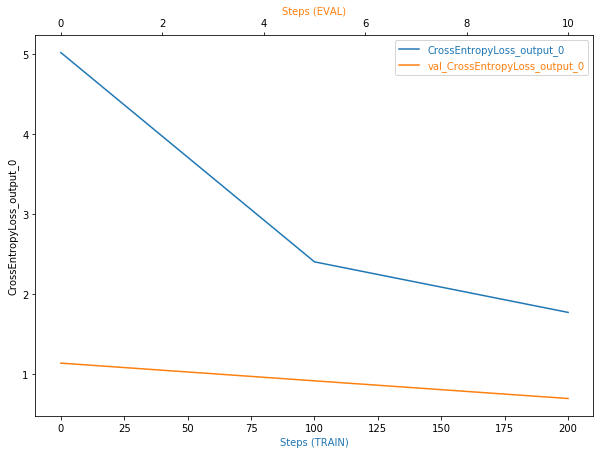

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

I am not sure if there is any anomolous behavior in my training, but it would seem loss has decreased. Also, there could be overfitting that could be resolved by early stopping training, there could be problem with loss not decreasing in whihc case, I think, more hyperparameter tuning is required, there could be poor weight initialization which, I think, could be resolved using a different model sicne we are fine tuning the model by freezing all the layers except for the last layer

In [27]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-015775941522/smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output


In [28]:
! aws s3 ls {rule_output_path} --recursive

2021-12-21 05:10:45     375409 smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-21 05:10:45     223337 smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-21 05:10:41        192 smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-21 05:10:41        200 smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-21 05:10:41       2132 smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-21 05:10:41        127 smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIn

In [29]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-015775941522/smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-015775941522/smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-015775941522/smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-015775941522/smdebugger-dogimage-breed-classificatio-2021-12-21-04-42-53-170/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-outpu

In [30]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [31]:
profiler_report_name

'ProfilerReport'

## Model Deploying

In [84]:
# imports fro model deployment
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

In [6]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class Image_Predictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(Image_Predictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [81]:
model_artificats_location = estimator.model_data
pytorch_model = PyTorchModel(model_data=model_artificats_location, framework_version="1.8",
                             py_version="py36", role=role, entry_point='inference.py',
                             predictor_cls=Image_Predictor)

In [82]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large") # TODO: Add your deployment configuration like instance type and number of instances

------!

In [40]:
# imports for image download
import requests as rq
from PIL import Image
import io
import json
from PIL import ImageFile
import os
import boto3
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [41]:
# TODO: Run an prediction on the endpoint
s3 = boto3.resource('s3')

def image_from_s3(bucket, key):

    bucket = s3.Bucket(bucket)
    image = bucket.Object(key)
    img_data = image.get().get('Body').read()

    return Image.open(io.BytesIO(img_data))

object_key = 'dogImages/test/007.American_foxhound/American_foxhound_00512.jpg'
img = image_from_s3(bucket, object_key)# TODO: Your code to load and preprocess image to send to endpoint for prediction

In [44]:
byteIO = io.BytesIO()
img.save(byteIO, "PNG")
byteIO.seek(0)
image_bytes = byteIO.read()

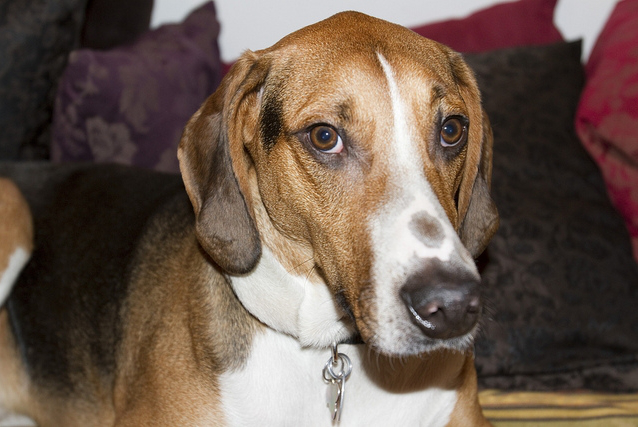

In [56]:
Image.open(io.BytesIO(image_bytes))

In [75]:
response=predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})

In [64]:
req_dict={"url": f"https://s3.console.aws.amazon.com/s3/object/sagemaker-studio-mb7oqzoi7lj?region=us-east-1&prefix=dogImages/test/020.Belgian_malinois/Belgian_malinois_01472.jpg"}

In [ ]:
json_response=predictor.predict(json.dumps(req_dict), initial_args={"ContentType": "application/json"})
print(type(json_response[0][0]))
print(json_response[0])

In [76]:
len(response[0])

133

In [79]:
response

[[-8.84546947479248,
  -4.185329437255859,
  -3.4848883152008057,
  -5.925583839416504,
  -7.007134437561035,
  -8.47021198272705,
  1.63994562625885,
  -2.831707715988159,
  -7.04250955581665,
  -4.649108409881592,
  -6.675975322723389,
  -6.882798194885254,
  -7.530662536621094,
  -0.3832356929779053,
  1.0710608959197998,
  1.5993177890777588,
  -5.9192280769348145,
  -6.763354778289795,
  -6.4529218673706055,
  -5.720978736877441,
  -7.876559734344482,
  -8.130457878112793,
  -7.034029960632324,
  -8.813165664672852,
  -2.982511043548584,
  -7.98024320602417,
  -1.269155740737915,
  -2.8678624629974365,
  -8.360982894897461,
  -7.069414138793945,
  -4.154220104217529,
  -6.302155017852783,
  -8.112747192382812,
  -1.7893670797348022,
  -7.247647762298584,
  -4.636431694030762,
  -2.8085291385650635,
  -8.121207237243652,
  -4.132903099060059,
  -3.588848829269409,
  -3.886646032333374,
  -7.5218939781188965,
  -5.644741535186768,
  -5.26220703125,
  -5.098669528961182,
  -6.5383720

In [77]:
import numpy as np
np.argmax(response, 1)

array([6])

In [78]:
response[0][6]

1.63994562625885

In [80]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()